## Detector de **SPAM**

### Objetivo do projeto

Este projeto tem o objetivo de mostrar como o **Multilayer Perceptron** pode ser utilizado para a detecção de SPAM. Embora o projeto esteja em Língua Portuguesa do Brasil, a base de SMS utilizada foi [encontrada no Kaggle](https://www.kaggle.com/code/dhgupta/bag-of-words-model/input), em Língua Inglesa, com o original disponibilizado em `data/spam.csv`.

Muitos projetos para a avaliação de SPAM em Língua Inglesa existem, assim deseja-se que este projeto faça tal classificação em Língua Portuguesa sendo necessário, para tanto, a tradução de toda a base de dados que será feita da seguinte forma:

1. Utilização de *small language models* no [Ollama](https://ollama.com) para rodar modelos de linguagem local;
1. Utilização do modelo [Improve Gramar](https://ollama.com/gnokit/improve-grammar) para a correção gramatical do texto na língua original, gerando o arquivo `data/spam_en.csv`;
1. Personalização do modelo [Gemma3 Translator](https://ollama.com/zongwei/gemma3-translator:1b) por meio do arquivo `en2pt.modelfile`, gerando o arquivo `data/spam_br.csv`.

### Análise dos dados

O primeiro passo em um projeto dessa natureza é analisar os dados. Para tanto, faremos uma leitura da base original e vamos contar o número palavras e frases. Ao final dessa tarefa, vamos decidir por executar ou não algum pré-processamento.

In [1]:
# Instalar pacotes necessários
%pip install -q pandas matplotlib seaborn wordcloud nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importar bibliotecas necessárias
import pandas as pd                    # Leitura e manipulação de dados em DataFrames
import matplotlib.pyplot as plt        # Gráficos e visualizações
import seaborn as sns                  # Gráficos estatísticos com uma estética aprimorada
from wordcloud import WordCloud        # Nuvens de palavras
import nltk                            # Processamento de linguagem natural (NLP)
from nltk.corpus import stopwords      # Lstas de stopwords (palavras irrelevantes)
from collections import Counter        # Frequência de elementos
import string                          # Manipulação de pontuação e caracteres especiais

In [3]:
# 2. Leitura do arquivo
spam = pd.read_csv("data/spam.csv", encoding='utf-8')   # Codificação para evitar erros
spam = spam[['Label', 'EmailText']]                     # manter apenas colunas relevantes
spam.columns = ['label', 'sms']                         # renomeia para dar melhor sentido
print(f'Linhas da base SPAM original: {spam.shape}')    # Imprime dimensão da base
spam.head()                                             # Imprime cinco registros

Linhas da base SPAM original: (5572, 2)


,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Estatísticas básicas
spam['word_count'] = spam['sms'].apply(lambda x: len(x.split()))
spam['char_count'] = spam['sms'].apply(len)

# Contar mensagens por categoria (ham/spam)
sms_by_label = spam['label'].value_counts().to_frame(name='Número de SMS')
sms_by_label.index.name = 'label'

# Média de palavras por mensagem
words_by_sms = spam.groupby('label')['word_count'].mean().to_frame(name="Média palavras por SMS")

# Juntar os dois DataFrames
sms_by_label.join(words_by_sms)

,Número de SMS,Média palavras por SMS
label,,
ham,4825,14.200622
spam,747,23.851406


In [5]:
# Maiores e menores SMSs

# Ordenar as cinco maiores e menores mensagens
maiores = spam.sort_values(by='char_count', ascending=False).head(5)
menores = spam.sort_values(by='char_count', ascending=True).head(5)
maiores_menores = pd.concat([maiores, menores], axis=0)
maiores_menores[['label', 'char_count', 'word_count', 'sms']].reset_index(drop=True)

,label,char_count,word_count,sms
0,ham,910,171,For me the love should start with attraction.i...
1,ham,790,162,The last thing i ever wanted to do was hurt yo...
2,ham,632,109,Indians r poor but India is not a poor country...
3,ham,611,103,How to Make a girl Happy? It's not at all diff...
4,ham,588,125,Sad story of a Man - Last week was my b'day. M...
5,ham,2,1,Ok
6,ham,2,1,Ok
7,ham,2,1,Ok
8,ham,2,1,Ok
9,ham,3,1,:)


### Resultado da análise

De acordo com a análise até o momento, temos um claro desbalanceamento nas classes.

| Classe | Nº de amostras | Palavras por mensagem (média) |
| ------ | -------------- | ----------------------------- |
| ham    | 4.825          | \~14                          |
| spam   | 747            | \~24                          |


A classe `ham` representa cerca de 87% dos dados, assim um modelo treinado sem cuidado pode aprender a simplesmente prever tudo como `ham` e ainda parecer `preciso`.

Foi o que aconteceu no projeto do diabetes, mas o Pedro, como bom estatístico, sempre tem uma boa explicação para os dados --- os dados dizem o que ele quer que diga. Os modelos apresentados lá, tanto a versão MLP quanto a logística, **não funcionavam**. Tentei instigar à correção, mas fui voto vencido.

Nesse caso, como estou fazendo sozinho, não vou permitir tal desbalanceamento. Para corrigir vou usar uma ou mais das possibilidades à seguir:

* Na hora de chamar o treinador MLP, dar peso maior para a classe "desbalanceada":
    ```
    mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42, class_weight='balanced')
    ```

* Usar o `SMOTE` para fazer criar amostras sintéticas da classe `spam`
    ```
    from imblearn.over_sampling import SMOTE

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    ```

* Remover dados da classe `ham`, mas não vou seguir essa abordagem dado que a quantidade de dados já está baixa.

* Uma outra atividade que podemos fazer é a produção de novos dados com base na correção gramatical do inglês e na tradução para o português, o que seria desejável.

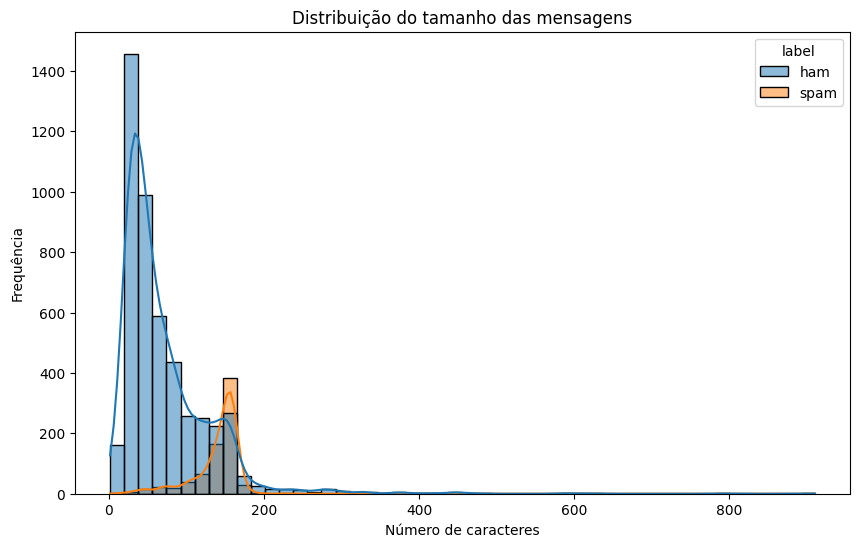

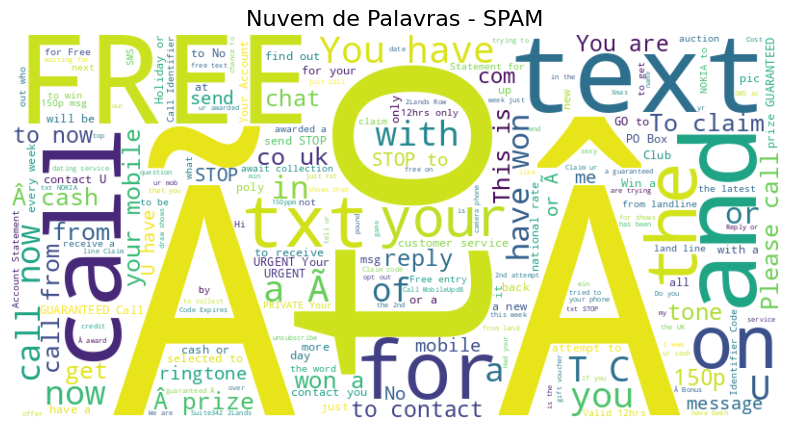

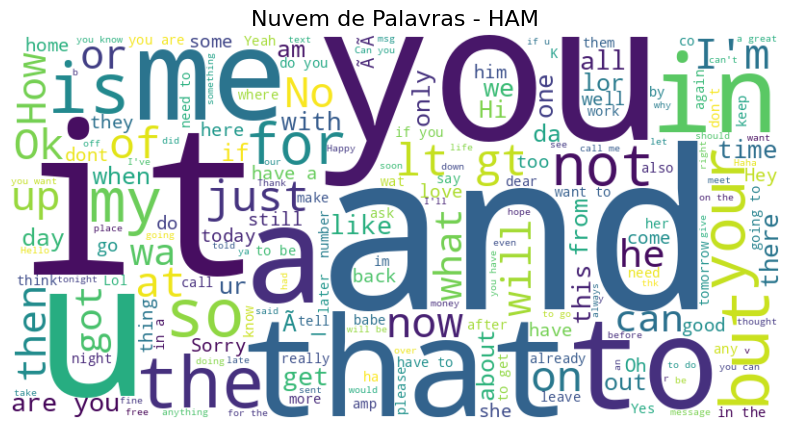

In [7]:


# 5. Visualização: histograma do comprimento das mensagens
plt.figure(figsize=(10,6))
sns.histplot(data=spam, x='char_count', hue='label', bins=50, kde=True)
plt.title("Distribuição do tamanho das mensagens")
plt.xlabel("Número de caracteres")
plt.ylabel("Frequência")
plt.show()

# 6. Nuvem de palavras (WordCloud)
def generate_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color='white', stopwords='english').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Juntar textos de cada categoria
spam_text = " ".join(spam[spam['label'] == 'spam']['sms'])
ham_text = " ".join(spam[spam['label'] == 'ham']['sms'])

generate_wordcloud(spam_text, "Nuvem de Palavras - SPAM")
generate_wordcloud(ham_text, "Nuvem de Palavras - HAM")

#### Análise de Frequência de Palavras

In [ ]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string

# Baixar recursos do nltk (apenas na 1ª vez)
nltk.download('punkt')
nltk.download('stopwords')

# Função de limpeza e tokenização
def get_word_frequencies(text_series):
    stop_words = set(stopwords.words('english'))
    all_words = []
    for message in text_series:
        # Tokenizar
        words = nltk.word_tokenize(message.lower())
        # Remover pontuações e stopwords
        words = [word for word in words if word.isalpha() and word not in stop_words]
        all_words.extend(words)
    return Counter(all_words)

# Frequências de palavras
spam_freq = get_word_frequencies(df[df['label'] == 'spam']['text'])
ham_freq = get_word_frequencies(df[df['label'] == 'ham']['text'])

# Mostrar 20 palavras mais comuns
print("Top 20 palavras em SPAM:")
print(spam_freq.most_common(20))

print("\nTop 20 palavras em HAM:")
print(ham_freq.most_common(20))


####  Palavras mais comuns

In [ ]:
# Converter para DataFrame e plotar
def plot_common_words(word_counter, title, n=20):
    common_words = word_counter.most_common(n)
    words, counts = zip(*common_words)
    plt.figure(figsize=(10,6))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.title(title)
    plt.xlabel("Frequência")
    plt.ylabel("Palavra")
    plt.show()

plot_common_words(spam_freq, "Palavras Mais Comuns em SPAM")
plot_common_words(ham_freq, "Palavras Mais Comuns em HAM")
